단백질 간 PPI 네트워크에서 edge type prediction (multi-class edge classification) 

- x_list를 feature로 쓰면 GAT이 attention을 통해 중요한 노드 feature 강조 
- ppi_df['mode']가 라벨 역할 학습 후 unknown edge에도 mode를 예측할 수 있어 새로운 관계 추천 가능 (biological insight!) 

- node feature(x)
    - x_tensor = node embedding/feature (x_list 기반)
    - GAT은 neighbor 노드와의 attention 계산에 이 feature를 사용해서 각 노드의 representation을 학습
    - 이렇게 학습된 노드 임베딩을 가지고 edge-level task (edge type prediction) 수행 가능

- edge index(edge_index)
    - 그래프 연결 정보 (src → dst)
    - Edge prediction 시, edge_index 기반으로 node pair representation을 가져와서 classifier에 넣음

- edge label(edge_label)
    - ppi_df['mode'] → multi-class 라벨
    - PyG에서 edge classification loss 계산 시 target으로 사용

- train
    - Node embedding → edge representation
    - CrossEntropyLoss/PyG의 EdgePredictionLoss 사용 → multi-class edge prediction
    - Unknown edge (ppi_df에 없는 edge)는 학습에서는 제외, 학습 후 예측 가능
    - GATConv로 노드 embedding 학습 후 edge-level classifier 연결 → edge type prediction 가능

In [ ]:
import numpy as np
import torch
import pandas as pd
from torch_geometric.data import Data

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.nn import GATConv
from torch.nn import LayerNorm
import torch.nn.functional as F
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR

import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import (accuracy_score, f1_score, classification_report, roc_auc_score, precision_recall_curve, auc)

In [2]:
torch.serialization.add_safe_globals([__import__('numpy').core.multiarray._reconstruct])

C:\Users\user\AppData\Local\Temp\ipykernel_3528\1857622832.py:1: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.
  torch.serialization.add_safe_globals([__import__('numpy').core.multiarray._reconstruct])


In [ ]:
# load data
edge_list_12 = np.load("C:/Users/user/Desktop/HanLab/GNN/edge classification_SHS27k/edge_list_12.npy", allow_pickle=True)
x_list = torch.load("C:/Users/user/Desktop/HanLab/GNN/edge classification_SHS27k/x_list.pt", map_location=torch.device('cpu'), weights_only=False)
ppi_df = pd.read_csv("C:/Users/user/Desktop/HanLab/GNN/edge classification_SHS27k/protein.actions.SHS27k.STRING.pro2.txt", sep="\t")
seq_protein = pd.read_csv("C:/Users/user/Desktop/HanLab/GNN/edge classification_SHS27k/protein.SHS27k.sequences.dictionary.pro3.tsv", sep="\t")

### preprocessing

##### check data

In [ ]:
# edge_list_12
print(type(edge_list_12))
print(edge_list_12.dtype)
print(edge_list_12.shape)
print(edge_list_12[:5])

<class 'numpy.ndarray'>
object
(1553,)
[list([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (8, 8), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (9, 58), (9, 59), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (10, 58), (10, 59), (11, 11), (11, 12), (11, 13), (11, 14), (11, 15), (11, 59), (12, 12), (12, 13), (12, 14), (12, 15), (12, 16), (12, 58), (12, 59), (12, 60), (13, 13), (13, 14), (13, 15), (13, 16), (13, 58), (13, 59), (13, 60), (13, 61), (14, 14), (14, 15), (14, 16), (14, 17), (14, 56), (14, 57), (14,

In [ ]:
# x_list
print(type(x_list))

# tensor라면, row 5개 확인
if isinstance(x_list, torch.Tensor):
    print(x_list[:5])
# dict나 list라면, key나 길이 확인
elif isinstance(x_list, dict):
    print(x_list.keys())
elif isinstance(x_list, list):
    print(len(x_list), "elements")
    print(x_list[0])

<class 'list'>
1553 elements
[[0.35441527 0.         0.         ... 0.         0.65916591 0.18434576]
 [0.38186158 0.33333333 0.         ... 0.         0.26539353 0.18434576]
 [0.38305489 0.         0.         ... 0.         0.76202345 0.18434576]
 ...
 [0.34725537 0.33333333 0.         ... 0.33333333 0.0410377  0.4509158 ]
 [0.81384248 1.         1.         ... 0.33333333 0.44007583 0.52721044]
 [1.         1.         1.         ... 1.         0.13616162 1.        ]]


In [113]:
# ppi_df
print(type(ppi_df))
print(ppi_df.shape)
print(ppi_df.head())
print(ppi_df.columns)
ppi_df['mode'].unique()

<class 'pandas.core.frame.DataFrame'>
(54812, 7)
              item_id_a             item_id_b        mode      action  \
0  9606.ENSP00000000233  9606.ENSP00000250971    reaction         NaN   
1  9606.ENSP00000000233  9606.ENSP00000250971    reaction         NaN   
2  9606.ENSP00000000233  9606.ENSP00000019317  activation  activation   
3  9606.ENSP00000000233  9606.ENSP00000216373    reaction         NaN   
4  9606.ENSP00000000233  9606.ENSP00000012443   catalysis         NaN   

  is_directional a_is_acting  score  
0              t           t    900  
1              t           f    900  
2              f           f    175  
3              f           f    161  
4              t           f    155  
Index(['item_id_a', 'item_id_b', 'mode', 'action', 'is_directional',
       'a_is_acting', 'score'],
      dtype='object')


array(['reaction', 'activation', 'catalysis', 'binding', 'ptmod',
       'inhibition', 'expression'], dtype=object)

In [7]:
# seq_protein
print(type(seq_protein))
print(seq_protein.shape)
print(seq_protein.head())
print(seq_protein.columns)

<class 'pandas.core.frame.DataFrame'>
(1552, 2)
   9606.ENSP00000000233  \
0  9606.ENSP00000250971   
1  9606.ENSP00000019317   
2  9606.ENSP00000216373   
3  9606.ENSP00000012443   
4  9606.ENSP00000005340   

  MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTIPTIGFNVETVEYKNICFTVWDVGGQDKIRPLWRHYFQNTQGLIFVVDSNDRERVQESADELQKMLQEDELRDAVLLVFANKQDMPNAMPVSELTDKLGLQHLRSRTWYVQATCATQGTGLYDGLDWLSHELSKR  
0  MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGER...                                                                                                                                    
1  MTECFLPPTSSPSEHRRVEHGSGLTRTPSSEEISPTKFPGLYRTGE...                                                                                                                                    
2  MQQAPQPYEFFSEENSPKWRGLLVSALRKVQEQVHPTLSANEESLY...                                                                                                                                    
3  MAMAEGERTECAEPPRDEPPADGALKRAEELKTQANDYFKAKDYEN

#### Data 객체 생성

In [69]:
# x
# x_list가 list of numpy arrays이면 tensor로 변환
x = torch.tensor(np.vstack(x_list), dtype=torch.float32)  # 2차원 tensor
print("x shape:", x.shape)  # (num_nodes, num_features)

# edge_list
# edge_list_12: list of lists of tuples 형태
edges = []
for sublist in edge_list_12:
    edges.extend(sublist)  # 모든 tuple flatten
# source, target 분리
src, dst = zip(*edges)
edge_index = torch.tensor([src, dst], dtype=torch.long)  # [2, num_edges]
print(edge_index.shape)

x shape: torch.Size([818994, 7])
torch.Size([2, 9644121])


In [70]:
# edge_label 생성

# node
# item_id mapping
node_id_list = seq_protein.iloc[:, 0].tolist()
node_id_to_idx = {node_id: idx for idx, node_id in enumerate(node_id_list)}

# x_list를 seq_protein 순서에 맞춰 선택 (extra node 버림)
x_array = np.vstack(x_list)  # x_list -> array
# seq_protein에 없는 node 인덱스 제거
valid_node_mask = [i < len(node_id_list) for i in range(len(x_array))]
x_array = x_array[:len(node_id_list), :]  # extra node 제거
x_tensor = torch.tensor(x_array, dtype=torch.float32)
print("x shape:", x_tensor.shape)  # (num_nodes, num_features)

# edge
valid_src = []
valid_dst = []

for s, d in zip(src, dst):
    if s < len(node_id_list) and d < len(node_id_list):  # seq_protein 범위 안에 있어야 함
        valid_src.append(s)
        valid_dst.append(d)

src_tensor = torch.tensor(valid_src, dtype=torch.long)
dst_tensor = torch.tensor(valid_dst, dtype=torch.long)
edge_index_tensor = torch.stack([src_tensor, dst_tensor], dim=0)
print("edge_index shape:", edge_index_tensor.shape)

x shape: torch.Size([1552, 7])
edge_index shape: torch.Size([2, 9468093])


In [71]:
# edge label 생성
mode_to_int = {m: i for i, m in enumerate(ppi_df['mode'].unique())}

# ppi_df를 dict로 변환: (item_id_a, item_id_b) -> mode_int
ppi_dict = {(row['item_id_a'], row['item_id_b']): mode_to_int[row['mode']] 
            for _, row in ppi_df.iterrows()}

edge_labels = []
valid_edge_mask = []

for s, d in zip(valid_src, valid_dst):
    node_a = node_id_list[s]
    node_b = node_id_list[d]
    key = (node_a, node_b)
    if key in ppi_dict:
        edge_labels.append(ppi_dict[key])
        valid_edge_mask.append(True)
    else:
        edge_labels.append(-1)   # 학습에서 무시
        valid_edge_mask.append(False)

# tensor 변환
edge_label_tensor = torch.tensor(edge_labels, dtype=torch.long)
valid_edge_mask_tensor = torch.tensor(valid_edge_mask, dtype=torch.bool)

# 유효한 edge만 필터링
edge_index_tensor = edge_index_tensor[:, valid_edge_mask_tensor]
edge_label_tensor = edge_label_tensor[valid_edge_mask_tensor]

print("Filtered edge_index shape:", edge_index_tensor.shape)
print("Filtered edge_label shape:", edge_label_tensor.shape)

Filtered edge_index shape: torch.Size([2, 477910])
Filtered edge_label shape: torch.Size([477910])


In [72]:
# Data 객체 생성
data = Data(
    x=x_tensor,
    edge_index=edge_index_tensor,
    edge_label=edge_label_tensor
)

print(data)

Data(x=[1552, 7], edge_index=[2, 477910], edge_label=[477910])


##### check data

In [25]:
# 기본속성
print(data.num_nodes)
print(data.num_edges)
print(data.num_node_features)
print(data.num_edge_features)  # edge feature 차원 (없으면 None)

1552
477910
7
0


In [ ]:
# edge
print(data.edge_index)
print(data.edge_label )        # edge classification label tensor
print(data.has_self_loops())   # False
print(data.has_isolated_nodes())   # True
# 전체 노드 수(1552) - edge_index에 나오는 엣지에 연결된 노드 수(1223) = 329개의 isolated node
print(data.is_undirected())   # False
print(data.is_directed())   # True
print(data.contains_isolated_nodes()) # isolate node 확인   # True

tensor([[  2,   3,   3,  ..., 437, 448, 448],
        [  5,   5,  10,  ..., 438, 449, 450]])
tensor([2, 5, 5,  ..., 0, 1, 3])
False
True
False
True
True


C:\Users\user\AppData\Local\Temp\ipykernel_8468\4147210030.py:8: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  print(data.contains_isolated_nodes()) # isolate node 확인   # True


In [17]:
# node
print(data.x)
print(data.x.shape)

tensor([[0.3544, 0.0000, 0.0000,  ..., 0.0000, 0.6592, 0.1843],
        [0.3819, 0.3333, 0.0000,  ..., 0.0000, 0.2654, 0.1843],
        [0.3831, 0.0000, 0.0000,  ..., 0.0000, 0.7620, 0.1843],
        ...,
        [0.3807, 0.0000, 0.0000,  ..., 0.0000, 0.6251, 0.1843],
        [0.8138, 1.0000, 1.0000,  ..., 0.3333, 0.4401, 0.5272],
        [0.3831, 0.0000, 0.0000,  ..., 0.0000, 0.7620, 0.1843]])
torch.Size([1552, 7])


In [ ]:
# edge feature
print(data.edge_label)
print(data.edge_label.shape)

tensor([2, 5, 5,  ..., 0, 1, 3])
torch.Size([477910])


In [21]:
# 전체 구조/유효성 검사
print(data.keys)
print(data.validate(raise_on_error=True))

<bound method BaseData.keys of Data(x=[1552, 7], edge_index=[2, 477910], edge_label=[477910])>
True


In [23]:
# index 범위, 중복 Nan
print(data.edge_index.min(), data.edge_index.max())  # 인덱스 범위 0~num_nodes-1
print(data.edge_index.unique().shape)               # unique node 수
print(torch.isnan(data.x).any())                    # feature에 NaN 있는지

tensor(0) tensor(1543)
torch.Size([1223])
tensor(False)


### data split

In [123]:
edges = data.edge_index
labels = data.edge_label

# -1인 레이블 제거
mask = labels != -1
edges = edges[:, mask]
labels = labels[mask]

In [124]:
# train/test split

# stratified split (클래스 비율 유지)
train_idx, test_idx = train_test_split(
    range(edges.shape[1]),
    train_size=0.8,
    stratify=labels.numpy(),
    random_state=42
)

train_edges = edges[:, train_idx]
train_labels = labels[train_idx]

test_edges = edges[:, test_idx]
test_labels = labels[test_idx]

# TensorDataset 생성
train_dataset = TensorDataset(torch.tensor(train_edges.T, dtype=torch.long),
                              torch.tensor(train_labels, dtype=torch.long))
test_dataset  = TensorDataset(torch.tensor(test_edges.T, dtype=torch.long),
                              torch.tensor(test_labels, dtype=torch.long))

# batch_size를 늘려 메모리 효율 개선 (예: 1024~8192 정도)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False)

C:\Users\user\AppData\Local\Temp\ipykernel_3528\3668039114.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_edges.T, dtype=torch.long),
C:\Users\user\AppData\Local\Temp\ipykernel_3528\3668039114.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_labels, dtype=torch.long))
C:\Users\user\AppData\Local\Temp\ipykernel_3528\3668039114.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset  = TensorDataset(torch.tensor(test_edges.T, dtype=torch.long),
C:\Users\

### model

In [125]:
class EdgeGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, negative_slope=0.2):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, add_self_loops=True)
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, add_self_loops=True)
        self.gat3 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, add_self_loops=True)
        self.lin = torch.nn.Linear(2 * hidden_channels * heads, out_channels)
        self.negative_slope = negative_slope

    def forward(self, x, edge_index, edge_label=None, return_attention=False):
        # node-level embedding
        # 첫 번째 GAT layer
        if return_attention:
            x, (edge_index_att, att_weights) = self.gat1(
                x, edge_index, return_attention_weights=True)
            x = F.leaky_relu(x, negative_slope=self.negative_slope)
        else:
            x = F.leaky_relu(self.gat1(x, edge_index), negative_slope=self.negative_slope)

        # 두 번째 GAT layer
        x = F.leaky_relu(self.gat2(x, edge_index), negative_slope=self.negative_slope)
        # 세 번째 GAT layer
        x = F.leaky_relu(self.gat3(x, edge_index), negative_slope=self.negative_slope)

        # edge feature
        src, dst = edge_index
        edge_feat = torch.cat([x[src], x[dst]], dim=-1)
        out = self.lin(edge_feat)
        prob = torch.softmax(out, dim=1)

        if return_attention:
            return out, prob, (edge_index_att, att_weights)
        else:
            return out, prob

##### MessagePassing 상속 직접 구현

GATConv 자체가 이미 MessagePassing을 상속받은 PyG 레이어
-> 직접 상속을 하려면 MessagePassing 상속으로 edge-level GATConv 직접 구현해야함

In [113]:
import torch
from torch import nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, softmax

class EdgeGATConv(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=4, concat=True, dropout=0.0, negative_slope=0.2):
        super().__init__(aggr='add')  # 'add', 'mean', 'max'
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope

        self.lin = nn.Linear(in_channels, out_channels * heads, bias=False)
        self.att = nn.Parameter(torch.Tensor(1, heads, 2 * out_channels))
        self.dropout = nn.Dropout(dropout)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin.weight)
        nn.init.xavier_uniform_(self.att)

    def forward(self, x, edge_index):
        # x: [num_nodes, in_channels]
        # edge_index: [2, num_edges]
        x = self.lin(x)  # [num_nodes, out_channels*heads]
        # reshape for multi-head: [num_nodes, heads, out_channels]
        x = x.view(-1, self.heads, self.out_channels)
        return x + self.propagate(edge_index, x=x)   # skip connection

    def message(self, x_i, x_j, edge_index, size_i):
        # x_i: target node, x_j: source node
        # Attention score
        x_cat = torch.cat([x_i, x_j], dim=-1)  # [E, 2*out_channels]
        alpha = (x_cat.unsqueeze(1) * self.att).sum(dim=-1)  # [E, heads]
        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, edge_index[0], num_nodes=size_i)
        alpha = self.dropout(alpha)
        # multiply attention score: [E, heads, out_channels]
        return x_j * alpha.unsqueeze(-1)

    def update(self, aggr_out):
        # aggr_out: [num_nodes, heads, out_channels]
        if self.concat:
            aggr_out = aggr_out.view(-1, self.heads * self.out_channels)
        else:
            aggr_out = aggr_out.mean(dim=1)
        return aggr_out

In [114]:
class EdgeGAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, negative_slope=0.2):
        super().__init__()
        # 3-layer EdgeGAT
        self.gat1 = EdgeGATConv(in_channels, hidden_channels, heads=heads, negative_slope=negative_slope)
        self.gat2 = EdgeGATConv(hidden_channels * heads, hidden_channels, heads=heads, negative_slope=negative_slope)
        self.gat3 = EdgeGATConv(hidden_channels * heads, hidden_channels, heads=heads, negative_slope=negative_slope)
        self.lin = nn.Linear(2 * hidden_channels * heads, out_channels)
        
    def forward(self, x, edge_index):
        x = F.leaky_relu(self.gat1(x, edge_index), negative_slope=self.gat1.negative_slope)
        x = F.leaky_relu(self.gat2(x, edge_index), negative_slope=self.gat2.negative_slope)
        x = F.leaky_relu(self.gat3(x, edge_index), negative_slope=self.gat3.negative_slope)

        src, dst = edge_index
        edge_feat = torch.cat([x[src], x[dst]], dim=-1)
        out = self.lin(edge_feat)
        prob = torch.softmax(out, dim=1)

        return out, prob

### train/test

In [131]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EdgeGAT(in_channels=data.x.shape[1], hidden_channels=256, out_channels=len(ppi_df['mode'].unique())).to(device)

# class 불균형 처리
ppi_df['mode_id'] = ppi_df['mode'].astype('category').cat.codes  # 문자열 → 정수
class_counts = np.bincount(ppi_df['mode_id'].values)  # 정수 컬럼 사용
class_weight = 1.0 / (class_counts + 1e-6)
class_weight = class_weight / class_weight.sum() * len(ppi_df['mode'].unique())
class_weight = torch.tensor(class_weight, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weight, ignore_index=-1, label_smoothing=0.05)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=1e-4)

def train(loader):
    model.train()

    total_count = 0
    total_loss = 0
    total_acc = 0
    for batch_edges, batch_labels in loader:
        batch_edges = batch_edges.t().to(device)  # [2, batch_size]
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        out, _ = model(data.x.to(device), batch_edges)  # full node feature, batch edges만 forward
        loss = criterion(out, batch_labels)
        loss.backward()
        optimizer.step()

        total_count += batch_labels.size(0)
        # 배치별 loss 합산
        total_loss += loss.item() * batch_labels.size(0)
        # accuarcy
        pred = out.argmax(dim=1)
        total_acc += int((pred == batch_labels).sum())

    avg_loss = total_loss / total_count
    avg_acc = total_acc / total_count
    return avg_loss, avg_acc

def test(loader):
    model.eval()
    
    total_count = 0
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for batch_edges, batch_labels in loader:
            batch_edges = batch_edges.t().to(device)
            batch_labels = batch_labels.to(device)

            out, _ = model(data.x.to(device), batch_edges)
            loss = criterion(out, batch_labels)

            total_count += batch_labels.size(0)
            # 배치별 loss 합산
            total_loss += loss.item() * batch_labels.size(0)
            # accuarcy
            pred = out.argmax(dim=1)
            total_acc += int((pred == batch_labels).sum())
    
    avg_loss = total_loss / total_count
    avg_acc = total_acc / total_count
    return avg_loss, avg_acc

In [132]:
best_val_loss = float('inf')
patience = 50
wait = 0
min_delta = 1e-3
best_model_state = None  # 최적 모델 임시 저장

train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(1, 301):
    train_loss, train_acc = train(train_loader)
    test_loss, test_acc = test(test_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Epoch: {epoch:03d}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    # Early stopping
    if test_loss < best_val_loss - min_delta:
        best_val_loss = test_loss
        wait = 0
        best_model_state = model.state_dict()  # 메모리에 임시 저장
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            # 최적 모델 한 번만 저장
            torch.save(best_model_state, "best_model.pt")
            break

Epoch: 001, Train Loss: 0.9583, Train Acc: 0.4297, Test Loss: 0.8481, Test Acc: 0.5225
Epoch: 002, Train Loss: 0.7760, Train Acc: 0.5565, Test Loss: 0.7176, Test Acc: 0.5992
Epoch: 003, Train Loss: 0.7003, Train Acc: 0.6155, Test Loss: 0.6742, Test Acc: 0.6311
Epoch: 004, Train Loss: 0.6691, Train Acc: 0.6392, Test Loss: 0.6515, Test Acc: 0.6489
Epoch: 005, Train Loss: 0.6514, Train Acc: 0.6528, Test Loss: 0.6458, Test Acc: 0.6518
Epoch: 006, Train Loss: 0.6326, Train Acc: 0.6649, Test Loss: 0.6261, Test Acc: 0.6713
Epoch: 007, Train Loss: 0.6250, Train Acc: 0.6715, Test Loss: 0.6120, Test Acc: 0.6673
Epoch: 008, Train Loss: 0.6150, Train Acc: 0.6779, Test Loss: 0.6112, Test Acc: 0.6770
Epoch: 009, Train Loss: 0.6097, Train Acc: 0.6835, Test Loss: 0.5985, Test Acc: 0.6906
Epoch: 010, Train Loss: 0.6028, Train Acc: 0.6870, Test Loss: 0.6321, Test Acc: 0.7014
Epoch: 011, Train Loss: 0.5992, Train Acc: 0.6903, Test Loss: 0.5868, Test Acc: 0.6933
Epoch: 012, Train Loss: 0.5952, Train Acc: 

In [133]:
# 학습 후 모델 평가 / 예측
model.eval()
with torch.no_grad():
    out, prob, (edge_index_att, att_weights) = model(data.x.to(device), data.edge_index.to(device), return_attention=True)
    pred = out.argmax(dim=1)
    prob = prob.cpu()
    pred = pred.cpu()
    edge_index_att = edge_index_att.cpu()
    att_weights = att_weights.cpu()
    y_true = data.edge_label.cpu()

##### check data

In [75]:
out, pred, prob, edge_index_att, att_weights

(tensor([[ 2.0458,  0.3845,  2.5110,  ..., -3.3917,  1.7643, -1.1559],
         [ 1.4372,  0.1406,  2.0757,  ..., -4.5705,  3.8444, -0.5489],
         [ 1.4126, -0.7970, -0.5147,  ..., -3.5153, -1.5993,  0.3503],
         ...,
         [ 1.5711,  0.2725, -1.7880,  ..., -0.2621, -1.9166, -1.7419],
         [ 1.4928,  2.2415, -1.0111,  ..., -2.4886, -2.8642,  0.3888],
         [ 1.6018,  2.2628, -0.9347,  ..., -2.4804, -2.8169,  0.1988]]),
 tensor([2, 5, 0,  ..., 0, 1, 1]),
 tensor([[2.7668e-01, 5.2536e-02, 4.4056e-01,  ..., 1.2036e-03, 2.0880e-01,
          1.1258e-02],
         [6.9266e-02, 1.8941e-02, 1.3116e-01,  ..., 1.7038e-04, 7.6903e-01,
          9.5051e-03],
         [4.2036e-01, 4.6130e-02, 6.1178e-02,  ..., 3.0441e-03, 2.0680e-02,
          1.4529e-01],
         ...,
         [6.0634e-01, 1.6549e-01, 2.1082e-02,  ..., 9.6963e-02, 1.8537e-02,
          2.2075e-02],
         [2.5176e-01, 5.3227e-01, 2.0585e-02,  ..., 4.6977e-03, 3.2267e-03,
          8.3469e-02],
         [2.77

In [ ]:
num_classes = len(torch.unique(pred))
num_classes

tensor([0, 1, 2, 3, 4, 5, 6])

### evaluation

In [ ]:
# Accuracy / F1 / Classification report
acc = accuracy_score(y_true, pred)
f1_macro = f1_score(y_true, pred, average='macro')
f1_micro = f1_score(y_true, pred, average='micro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 (macro): {f1_macro:.4f}")
print(f"F1 (micro): {f1_micro:.4f}")
print("\nClassification report:\n")
print(classification_report(y_true, pred))

Accuracy: 0.4270
F1 (macro): 0.2311
F1 (micro): 0.4270

Classification report:

              precision    recall  f1-score   support

           0       0.54      0.59      0.56    195656
           1       0.51      0.11      0.18     57460
           2       0.16      0.10      0.12     36791
           3       0.39      0.56      0.46    125888
           4       0.03      0.02      0.02     21424
           5       0.22      0.35      0.27     20645
           6       0.06      0.00      0.00     20046

    accuracy                           0.43    477910
   macro avg       0.27      0.25      0.23    477910
weighted avg       0.41      0.43      0.40    477910



In [ ]:
# ROC-AUC & PR-AUC (multi-class)

# ROC-AUC (one-vs-rest)
try:
    roc_auc = roc_auc_score(y_true, prob.numpy(), multi_class='ovr')
    print(f"ROC-AUC (OvR): {roc_auc:.4f}")
except:
    print("ROC-AUC 계산 실패: 클래스가 2개 이하거나 prob shape 문제일 수 있음")

# PR-AUC
pr_aucs = {}
for class_idx in range(prob.shape[1]):
    precision, recall, _ = precision_recall_curve((y_true==class_idx).numpy(), prob[:, class_idx].numpy())
    pr_auc = auc(recall, precision)
    pr_aucs[class_idx] = pr_auc
print("PR-AUC per class:", pr_aucs)

ROC-AUC (OvR): 0.6848
PR-AUC per class: {0: 0.5436059694408939, 1: 0.2199336777943336, 2: 0.09520879730673079, 3: 0.46419714203615914, 4: 0.07198410832754, 5: 0.16210183851832044, 6: 0.22094786464774452}


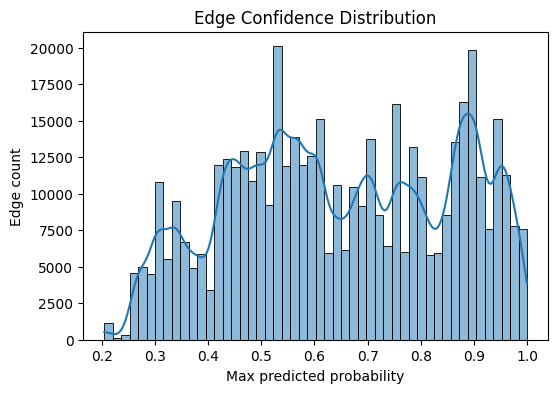

In [ ]:
# Edge confidence distribution 확인

# 확률 최대값을 edge confidence로 정의
edge_confidence = prob.max(dim=1).values
plt.figure(figsize=(6,4))
sns.histplot(edge_confidence, bins=50, kde=True)
plt.title("Edge Confidence Distribution")
plt.xlabel("Max predicted probability")
plt.ylabel("Edge count")
plt.show()

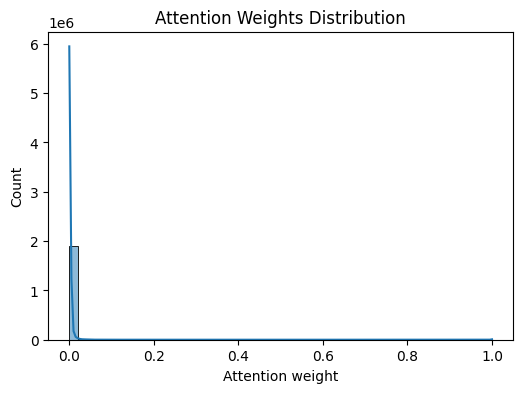

In [ ]:
# Attention weight 확인

# node attention 분포 확인
plt.figure(figsize=(6,4))
sns.histplot(att_weights.flatten().numpy(), bins=50, kde=True)
plt.title("Attention Weights Distribution")
plt.xlabel("Attention weight")
plt.ylabel("Count")
plt.show()

### visualization

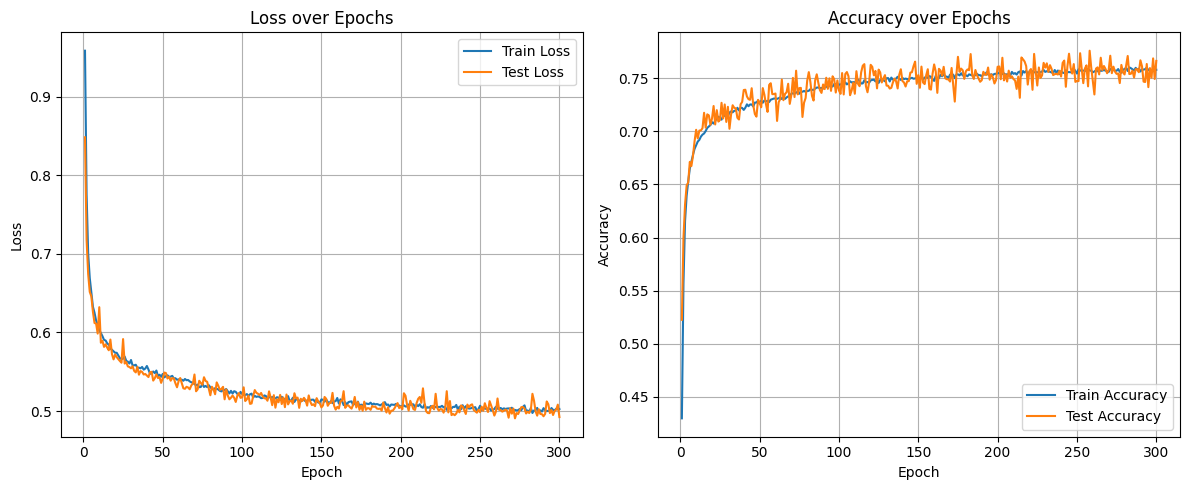

In [139]:
# 학습 과정 시각화 (Loss & Accuracy)
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

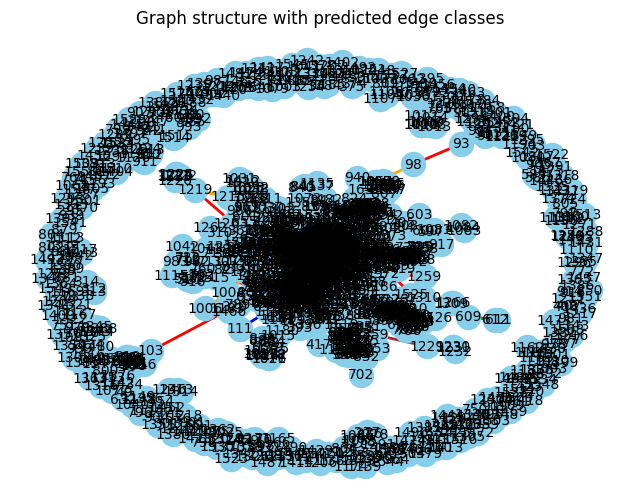

In [ ]:
# 학습 후 최종 output 시각화 : Graph 구조 시각화 (노드, 엣지)

# Graph 구조 시각화
G = nx.Graph()

# 노드 추가
num_nodes = data.x.shape[0]
G.add_nodes_from(range(num_nodes))

# 엣지 추가 (edge_index는 [2, num_edges] 형태)
edges = data.edge_index.cpu().numpy()
G.add_edges_from(edges.T)

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # 노드 위치 자동 배치

# 노드 색상은 그냥 균일하게
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=300)
# 엣지 색상은 예측 클래스 기반
color_map = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink']
edge_colors = [color_map[c] for c in pred.numpy()]
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Graph structure with predicted edge classes")
plt.axis('off')
plt.show()

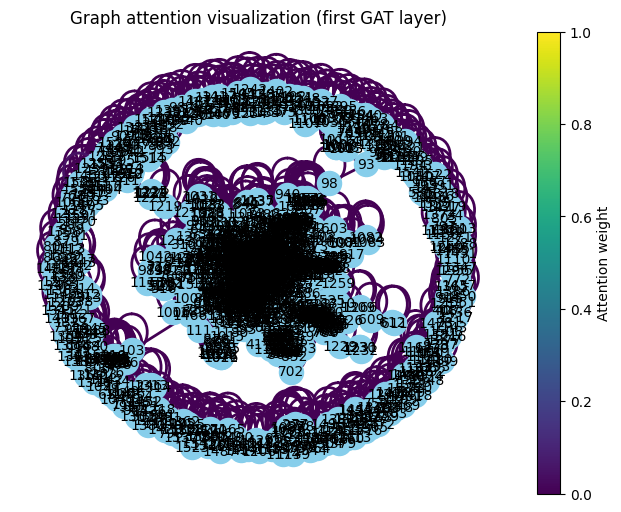

In [ ]:
# Attention 시각화 (GAT)

# Attention 결과 시각화 (첫 GAT layer)
# edge_index_att와 att_weights를 사용
# Attention 시각화 (GAT)
G_att = nx.Graph()
G_att.add_nodes_from(range(num_nodes))
att_edges = edge_index_att.cpu().numpy()
G_att.add_edges_from(att_edges.T)

# node 위치
pos = nx.spring_layout(G_att, seed=42)

# attention 값을 edge 색상으로 변환
att_values = att_weights.cpu().numpy().flatten()  # 1차원으로 변환
norm = mpl.colors.Normalize(vmin=att_values.min(), vmax=att_values.max())
edge_colors_rgba = plt.cm.viridis(norm(att_values))
  # RGBA 배열 생성 # (num_edges, 4) 형태


# 만약 shape가 (num_edges, 1, 4)라면 reshape
if edge_colors_rgba.ndim == 3:
    edge_colors_rgba = edge_colors_rgba.reshape(edge_colors_rgba.shape[0], 4)


# Figure와 Axes 명시적으로 생성
fig, ax = plt.subplots(figsize=(8,6))
nx.draw_networkx_nodes(G_att, pos, node_color='skyblue', node_size=300)
nx.draw_networkx_edges(G_att, pos, edge_color=edge_colors_rgba, width=2)
nx.draw_networkx_labels(G_att, pos, font_size=10)

# Colorbar 생성
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array(att_values)
fig.colorbar(sm, ax=ax, label="Attention weight")

ax.set_title("Graph attention visualization (first GAT layer)")
ax.axis('off')
plt.show()

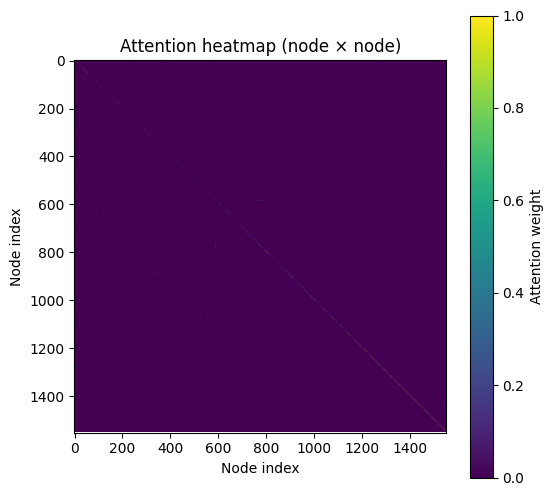

In [ ]:
# Node × Node adjacency heatmap

# GAT attention은 edge 단위이므로, attention 행렬을 adjacency matrix 형태로 만들어 2D heatmap으로 표시 가능:
num_nodes = data.x.shape[0]
att_matrix = np.zeros((num_nodes, num_nodes))

edges = edge_index_att.cpu().numpy()
att_vals = att_weights.cpu().numpy()  # shape: (num_edges, num_heads)

# 각 엣지에 대해 헤드 평균
att_vals_mean = att_vals.mean(axis=1)  # shape: (num_edges,)

for i, (src, dst) in enumerate(edges.T):
    att_matrix[src, dst] = att_vals_mean[i]
    att_matrix[dst, src] = att_vals_mean[i]  # 무향 그래프라면 대칭

plt.figure(figsize=(6,6))
plt.imshow(att_matrix, cmap='viridis')
plt.colorbar(label="Attention weight")
plt.title("Attention heatmap (node × node)")
plt.xlabel("Node index")
plt.ylabel("Node index")
plt.show()


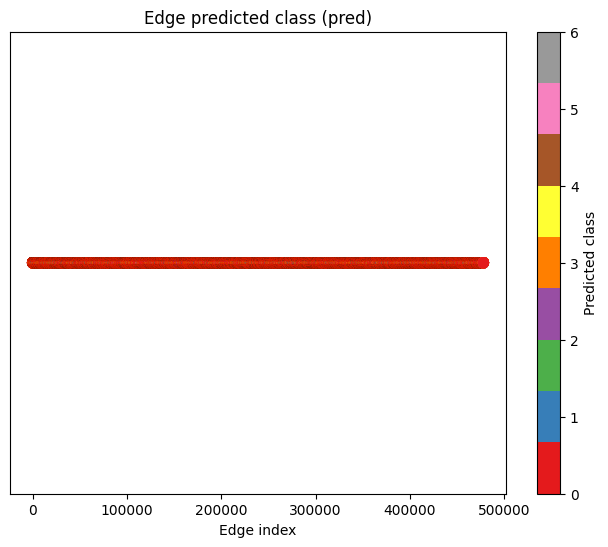

In [ ]:
# Edge 클래스 색상 (pred 기반)

# 각 edge가 어느 클래스인지 확인 가능
edge_colors = pred.numpy()
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(edge_colors)), np.zeros_like(edge_colors), c=edge_colors, cmap='Set1', s=50)
plt.colorbar(label="Predicted class")
plt.title("Edge predicted class (pred)")
plt.xlabel("Edge index")
plt.yticks([])
plt.show()

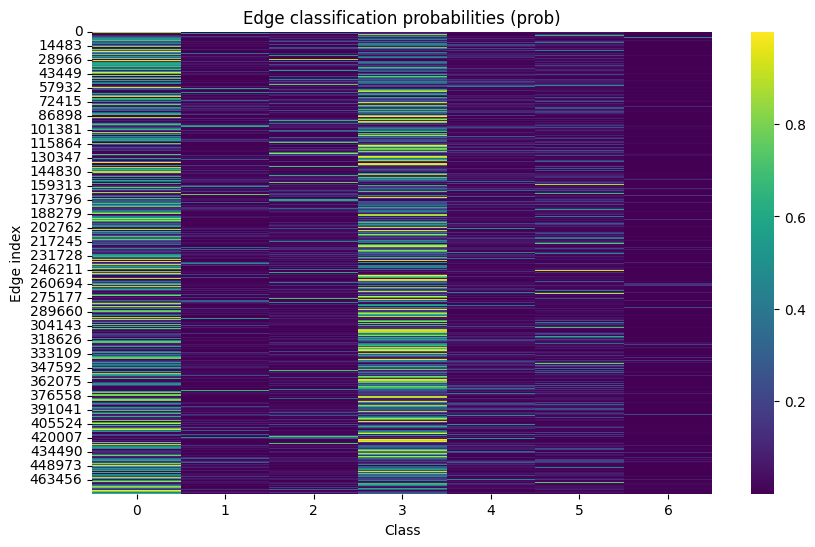

In [ ]:
# Edge × Class heatmap

# prob 전체를 heatmap으로 표현
# 각 edge가 각 클래스에 대해 가진 확률 확인 가능
plt.figure(figsize=(10,6))
sns.heatmap(prob.numpy(), cmap='viridis')
plt.xlabel("Class")
plt.ylabel("Edge index")
plt.title("Edge classification probabilities (prob)")
plt.show()